In [146]:
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
reload(functions)

<module 'functions' from 'c:\\Users\\veeti\\OneDrive - LUT University\\ADAML\\adaml-ml-project\\functions.py'>

In [147]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df, start_date="17/12/2006", end_date="26/11/2010")

In [148]:
class EnergyData(Dataset):
    def __init__(self, features, targets, window):
        self.features = features
        self.targets = targets
        self.window = window
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[index+self.window]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True) # RNN layer
        self.fc = nn.Linear(hidden_size, output_size) # output layer
        
    def forward(self, x):
        #print("Input shape:", x.shape)
        h0 = torch.zeros(self.n_layers, x.shape[0], self.hidden_size) # [num_layers, batch_size, hidden_size]
        output, _ = self.rnn(x, h0) # RNN forward pass
        output = self.fc(output[:, -1, :]) # use the last time step's output for classification
        return output

In [ ]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]

# Decided to only use the last year as "validation" set in the end, not forecasting currently...
train_data = train_val_data
val_data = test_data


In [170]:
input_size = 6 # number of features
hidden_size = 32
output_size = 1 # predicting a single value
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
n_epochs = 20
learning_rate = 0.001
window = 24


Y_train = train_data["Global_active_power"].values
X_train = train_data.iloc[:, 1:len(train_data.columns)].values

X_val = val_data.iloc[:, 1:len(val_data.columns)].values
Y_val = val_data["Global_active_power"].values


scalerX = StandardScaler()
scalerY = StandardScaler()

train_X = scalerX.fit_transform(X_train)
val_X = scalerX.transform(X_val)

train_Y = scalerY.fit_transform(Y_train.reshape(-1, 1))
val_Y = scalerY.transform(Y_val.reshape(-1, 1))

trainData = EnergyData(train_X, train_Y, window)
valData = EnergyData(val_X, val_Y, window)

trainLoader = DataLoader(trainData, batch_size=32, shuffle=False)
valLoader = DataLoader(valData, batch_size=32, shuffle=False)

model = RNNModel(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainLosses = []
valLosses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in trainLoader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred=model(X_batch)
        loss=loss_fn(pred,y_batch)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    preds = []
    truevalids = []
    with torch.inference_mode():
        val_loss = 0
        for X_batch, y_batch in valLoader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            val_loss += loss.item()
            preds.append(pred.detach().cpu().numpy())
            truevalids.append(y_batch.detach().cpu().numpy())

    print(f"Epoch {epoch+1} / {n_epochs}, Training Loss: {epoch_loss/len(trainLoader):.4f}, Validation Loss: {val_loss/len(valLoader):.4f}")
    trainLosses.append(epoch_loss/len(trainLoader))
    valLosses.append(val_loss/len(valLoader))

# Lets store last epoch values...
preds_array = np.concatenate(preds, axis=0).flatten()
truevalids_array =  np.concatenate(truevalids, axis=0).flatten()

preds_real = scalerY.inverse_transform(preds_array.reshape(-1, 1))
truevalids_real = scalerY.inverse_transform(truevalids_array.reshape(-1, 1))




Epoch 1 / 20, Training Loss: 0.4874, Validation Loss: 0.4018
Epoch 2 / 20, Training Loss: 0.4092, Validation Loss: 0.3536
Epoch 3 / 20, Training Loss: 0.3873, Validation Loss: 0.3381
Epoch 4 / 20, Training Loss: 0.3781, Validation Loss: 0.3361
Epoch 5 / 20, Training Loss: 0.3718, Validation Loss: 0.3381
Epoch 6 / 20, Training Loss: 0.3672, Validation Loss: 0.3399
Epoch 7 / 20, Training Loss: 0.3639, Validation Loss: 0.3390
Epoch 8 / 20, Training Loss: 0.3611, Validation Loss: 0.3383
Epoch 9 / 20, Training Loss: 0.3587, Validation Loss: 0.3376
Epoch 10 / 20, Training Loss: 0.3564, Validation Loss: 0.3368
Epoch 11 / 20, Training Loss: 0.3541, Validation Loss: 0.3351
Epoch 12 / 20, Training Loss: 0.3521, Validation Loss: 0.3329
Epoch 13 / 20, Training Loss: 0.3502, Validation Loss: 0.3316
Epoch 14 / 20, Training Loss: 0.3488, Validation Loss: 0.3307
Epoch 15 / 20, Training Loss: 0.3466, Validation Loss: 0.3300
Epoch 16 / 20, Training Loss: 0.3453, Validation Loss: 0.3313
Epoch 17 / 20, Tr

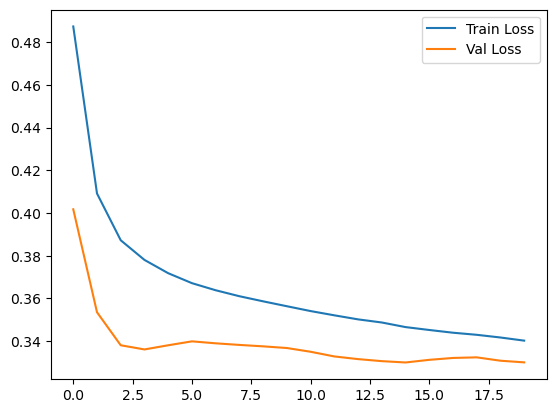

In [171]:
plt.figure()
plt.plot(trainLosses, label="Train Loss")
plt.plot(valLosses, label="Val Loss")
plt.legend()
plt.show()


In [172]:
print("true valids shape:", truevalids_array.shape)
print("preds shape:", preds_array.shape)

true valids shape: (8736,)
preds shape: (8736,)


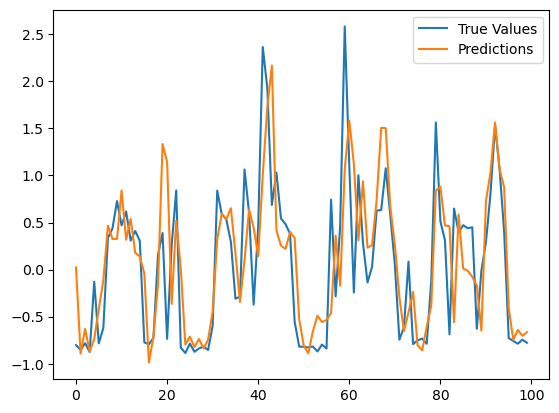

In [173]:
plt.figure()
plt.plot(truevalids_array[:100])
plt.plot(preds_array[:100])
plt.legend(["True Values", "Predictions"])
plt.show()

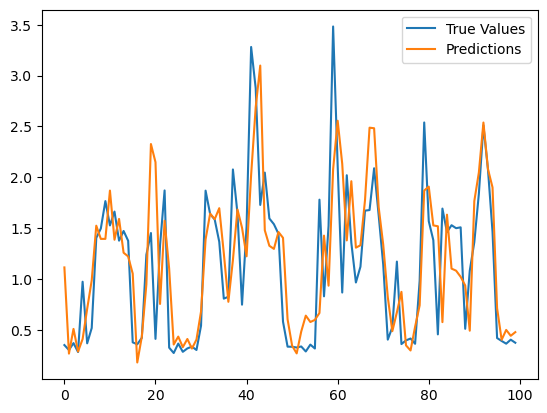

In [174]:
plt.figure()
plt.plot(truevalids_real[:100])
plt.plot(preds_real[:100])
plt.legend(["True Values", "Predictions"])
plt.show()

In [175]:

# input_size = X.shape[1] # number of features
# hidden_size = 64
# output_size = 1 # predicting a single value
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loss_fn = nn.MSELoss()
# n_epochs = 50
# learning_rate = 0.001
# window = 24

# foldLosses = [[] for _ in range(nFolds)]
# trainLosses = [[] for _ in range(nFolds)]
# valLosses = [[] for _ in range(nFolds)]

# preds = []
# truevalids = []




# for i in range(len(folds)):
#     scalerX = StandardScaler()
#     scalerY = StandardScaler()

#     train_idx, val_idx = folds[i]
#     train_X, val_X = X.iloc[train_idx].values, X.iloc[val_idx].values
#     train_Y, val_Y = Y.iloc[train_idx].values, Y.iloc[val_idx].values

#     train_X = scalerX.fit_transform(train_X)
#     val_X = scalerX.transform(val_X)

#     train_Y = scalerY.fit_transform(train_Y.reshape(-1, 1))
#     val_Y = scalerY.transform(val_Y.reshape(-1, 1))

#     trainData = EnergyData(train_X, train_Y, window)
#     valData = EnergyData(val_X, val_Y, window)

#     trainLoader = DataLoader(trainData, batch_size=32, shuffle=True)
#     valLoader = DataLoader(valData, batch_size=32, shuffle=False)

#     model = RNNModel(input_size, hidden_size, output_size).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     for epoch in range(n_epochs):
#         model.train()
#         epoch_loss = 0
#         for X_batch, y_batch in trainLoader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             # print("Batch X shape:", X_batch.shape)
#             # print("Batch y shape:", y_batch.shape)
#             #Prediction and loss
#             pred=model(X_batch)
#             # print("Prediction shape:", pred.shape)
#             # print("Prediction: ", pred)
#             loss=loss_fn(pred,y_batch)
#             epoch_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # pred_real = scalerY.inverse_transform(pred.detach().cpu().numpy())
#             # y_real = scalerY.inverse_transform(y_batch.detach().cpu().numpy())
#             # print(pred_real, y_real)

#         model.eval()
#         with torch.inference_mode():
#             val_loss = 0
#             for X_batch, y_batch in valLoader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 pred = model(X_batch)
#                 loss = loss_fn(pred, y_batch)
#                 val_loss += loss.item()
#                 preds.append(pred.detach().cpu().numpy())
#                 truevalids.append(y_batch.detach().cpu().numpy())

#         print(f"Fold {i+1}, Epoch {epoch+1} / {n_epochs}, Training Loss: {epoch_loss/len(trainLoader):.4f}, Validation Loss: {val_loss/len(valLoader):.4f}")

#         trainLosses[i].append(epoch_loss/len(trainLoader))
#         valLosses[i].append(val_loss/len(valLoader))

#     foldLosses[i].append(val_loss/len(valLoader)) # last validation loss of the fold (not necessary but easy way :D)
    
#     #torch.save(model.state_dict(), f"models/rnn_fold_{i+1}.pth")
#     break # fold 1 test
